In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#association rules
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

#clustering
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from IPython.display import display

## 1. Checking whether there is any relationship between information about superheroes and superpowers they have

### Data preparation

In [602]:
heroes_info = pd.read_csv('heroes_information.csv')
super_powers = pd.read_csv('super_hero_powers.csv')

In [603]:
heroes_info.columns
# heroes_info.head()

Index(['Unnamed: 0', 'name', 'Gender', 'Eye color', 'Race', 'Hair color',
       'Height', 'Publisher', 'Skin color', 'Alignment', 'Weight'],
      dtype='object')

In [604]:
heroes_info = heroes_info.drop('Unnamed: 0', axis=1)
heroes_info.head()

,name,Gender,Eye color,Race,Hair color,Height,Publisher,Skin color,Alignment,Weight
0,A-Bomb,Male,yellow,Human,No Hair,203.0,Marvel Comics,-,good,441.0
1,Abe Sapien,Male,blue,Icthyo Sapien,No Hair,191.0,Dark Horse Comics,blue,good,65.0
2,Abin Sur,Male,blue,Ungaran,No Hair,185.0,DC Comics,red,good,90.0
3,Abomination,Male,green,Human / Radiation,No Hair,203.0,Marvel Comics,-,bad,441.0
4,Abraxas,Male,blue,Cosmic Entity,Black,-99.0,Marvel Comics,-,bad,-99.0


In [605]:
super_powers.head()

,hero_names,Agility,Accelerated Healing,Lantern Power Ring,Dimensional Awareness,Cold Resistance,Durability,Stealth,Energy Absorption,Flight,...,Web Creation,Reality Warping,Odin Force,Symbiote Costume,Speed Force,Phoenix Force,Molecular Dissipation,Vision - Cryo,Omnipresent,Omniscient
0,3-D Man,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,A-Bomb,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Abe Sapien,True,True,False,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Abin Sur,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,Abomination,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [606]:
# Change the column name so that it can be used as id for datasets merge
column_names = super_powers.columns.values
column_names[0] = 'name'
super_powers.columns = column_names

In [607]:
# Encoding of nulls and surely incorrect data
heroes_info['Weight'].replace(-99.0, np.nan, inplace=True)
heroes_info['Height'].replace(-99.0, np.nan, inplace=True)
heroes_info.replace('-', np.nan,inplace=True)

In [608]:
heroes_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734 entries, 0 to 733
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        734 non-null    object 
 1   Gender      705 non-null    object 
 2   Eye color   562 non-null    object 
 3   Race        430 non-null    object 
 4   Hair color  562 non-null    object 
 5   Height      517 non-null    float64
 6   Publisher   719 non-null    object 
 7   Skin color  72 non-null     object 
 8   Alignment   727 non-null    object 
 9   Weight      495 non-null    float64
dtypes: float64(2), object(8)
memory usage: 57.5+ KB


Variable *Skin color* is deleted, as it contains too many null values.

In [609]:
heroes_info = heroes_info.drop('Skin color', axis=1)

In [610]:
data = pd.merge(heroes_info, super_powers, on='name')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 660 entries, 0 to 659
Columns: 176 entries, name to Omniscient
dtypes: bool(167), float64(2), object(7)
memory usage: 159.2+ KB


In [611]:
print(data.isna().sum()['Weight'])
print(data.isna().sum()['Height'])

192
170


#### Fill in the missing data on height and weisgh - done based on the mean value of race and gender of the specific hero

In [612]:
data['Height'] = data['Height'].fillna(data.groupby(['Race','Gender'])['Height'].transform('mean'))
data['Weight'] = data['Weight'].fillna(data.groupby(['Race','Gender'])['Weight'].transform('mean'))

In [613]:
print(data.isna().sum()['Weight'])
print(data.isna().sum()['Height'])

118
108


In [614]:
data[data['Height'].isna()].head()
# data[data['Weight'].isna()]

,name,Gender,Eye color,Race,Hair color,Height,Publisher,Alignment,Weight,Agility,...,Web Creation,Reality Warping,Odin Force,Symbiote Costume,Speed Force,Phoenix Force,Molecular Dissipation,Vision - Cryo,Omnipresent,Omniscient
6,Adam Monroe,Male,blue,NaN,Blond,NaN,NBC - Heroes,good,NaN,False,...,False,False,False,False,False,False,False,False,False,False
14,Alex Woolsly,Male,NaN,NaN,NaN,NaN,NBC - Heroes,good,NaN,False,...,False,False,False,False,False,False,False,False,False,False
16,Allan Quatermain,Male,NaN,NaN,NaN,NaN,Wildstorm,good,NaN,False,...,False,False,False,False,False,False,False,False,False,False
19,Ando Masahashi,Male,NaN,NaN,NaN,NaN,NBC - Heroes,good,NaN,False,...,False,False,False,False,False,False,False,False,False,False
24,Angela,Female,NaN,NaN,NaN,NaN,Image Comics,bad,NaN,False,...,False,False,False,False,False,False,False,False,False,False


In [615]:
# data[data.isnull().sum(axis=1) < 3].count()

Missing data still exists, and as can be seen most of the heros don't have the big part of the information. Having that in mind, I decided to drop those rows and analyse only the heroes with full information.

In [616]:
data.dropna(inplace=True)

In [617]:
data.head()

,name,Gender,Eye color,Race,Hair color,Height,Publisher,Alignment,Weight,Agility,...,Web Creation,Reality Warping,Odin Force,Symbiote Costume,Speed Force,Phoenix Force,Molecular Dissipation,Vision - Cryo,Omnipresent,Omniscient
0,A-Bomb,Male,yellow,Human,No Hair,203.0,Marvel Comics,good,441.0,False,...,False,False,False,False,False,False,False,False,False,False
1,Abe Sapien,Male,blue,Icthyo Sapien,No Hair,191.0,Dark Horse Comics,good,65.0,True,...,False,False,False,False,False,False,False,False,False,False
2,Abin Sur,Male,blue,Ungaran,No Hair,185.0,DC Comics,good,90.0,False,...,False,False,False,False,False,False,False,False,False,False
3,Abomination,Male,green,Human / Radiation,No Hair,203.0,Marvel Comics,bad,441.0,False,...,False,False,False,False,False,False,False,False,False,False
4,Abraxas,Male,blue,Cosmic Entity,Black,876.0,Marvel Comics,bad,16.0,False,...,False,False,False,False,False,False,False,False,False,False


In [618]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336 entries, 0 to 658
Columns: 176 entries, name to Omniscient
dtypes: bool(167), float64(2), object(7)
memory usage: 81.0+ KB


#### Converting categorical variables to binary ones

In [619]:
data = pd.get_dummies(data, columns=['Gender', 'Eye color', 'Race',
                                     'Hair color','Publisher','Alignment'],
                      drop_first=True)
data.replace(0, False, inplace=True)
data.replace(1, True, inplace=True)

In [620]:
data.head()

,name,Height,Weight,Agility,Accelerated Healing,Lantern Power Ring,Dimensional Awareness,Cold Resistance,Durability,Stealth,...,Publisher_Icon Comics,Publisher_Image Comics,Publisher_J. K. Rowling,Publisher_Marvel Comics,Publisher_Microsoft,Publisher_Sony Pictures,Publisher_Star Trek,Publisher_Titan Books,Alignment_good,Alignment_neutral
0,A-Bomb,203.0,441.0,False,True,False,False,False,True,False,...,False,False,False,True,False,False,False,False,True,False
1,Abe Sapien,191.0,65.0,True,True,False,False,True,True,False,...,False,False,False,False,False,False,False,False,True,False
2,Abin Sur,185.0,90.0,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,Abomination,203.0,441.0,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
4,Abraxas,876.0,16.0,False,False,False,True,False,False,False,...,False,False,False,True,False,False,False,False,False,False


### Pearson Correlation

In [621]:
corr_matrix = data.corr().abs()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
corr_matrix = corr_matrix.mask(mask)

In [622]:
corr_matrix

,Height,Weight,Agility,Accelerated Healing,Lantern Power Ring,Dimensional Awareness,Cold Resistance,Durability,Stealth,Energy Absorption,...,Publisher_Icon Comics,Publisher_Image Comics,Publisher_J. K. Rowling,Publisher_Marvel Comics,Publisher_Microsoft,Publisher_Sony Pictures,Publisher_Star Trek,Publisher_Titan Books,Alignment_good,Alignment_neutral
Height,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Weight,0.131475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Agility,0.086710,0.001647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Accelerated Healing,0.082717,0.211724,0.208345,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Lantern Power Ring,0.002086,0.001082,0.024374,0.048599,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Publisher_Sony Pictures,0.001323,0.006398,0.052718,0.072361,0.009064,0.011811,0.018926,0.055953,0.035059,0.021485,...,0.002985,0.002985,0.002985,0.061951,0.002985,NaN,NaN,NaN,NaN,NaN
Publisher_Star Trek,0.001181,0.007493,0.035051,0.071666,0.015747,0.020518,0.069413,0.029387,0.078308,0.037325,...,0.005186,0.005186,0.005186,0.107624,0.005186,0.005186,NaN,NaN,NaN,NaN
Publisher_Titan Books,0.004997,0.006398,0.056623,0.041253,0.009064,0.011811,0.018926,0.055953,0.085144,0.021485,...,0.002985,0.002985,0.002985,0.061951,0.002985,0.002985,0.005186,NaN,NaN,NaN
Alignment_good,0.117601,0.258533,0.075610,0.036916,0.114180,0.098083,0.011774,0.067387,0.105153,0.046110,...,0.037603,0.037603,0.037603,0.003212,0.037603,0.037603,0.065326,0.037603,NaN,NaN


In [623]:
corr_matrix = corr_matrix.stack()
power_cols = data.columns[3:168].tolist()

In [624]:
correlation_list = []
for idx, x in corr_matrix[tri_df > 0.4].sort_values(ascending=False).iteritems():
    if ((idx[1] in power_cols) & (idx[0] not in power_cols)):
        print(idx,x)

('Race_Bizarro', 'Vision - Cryo') 1.0
('Race_Symbiote', 'Symbiote Costume') 0.863397096042455
('Publisher_George Lucas', 'The Force') 0.814033538872716
('Race_Korugaran', 'Qwardian Power Ring') 0.7060506091538817
('Eye color_green / blue', 'Adaptation') 0.7060506091538815
('Race_Human / Cosmic', 'Nova Force') 0.7060506091538814
('Race_Cosmic Entity', 'Power Cosmic') 0.7049865162000983
('Race_Kryptonian', 'Vision - Heat') 0.6721222000114645
('Race_Kryptonian', 'Vision - Microscopic') 0.6466697906828645
('Race_Kryptonian', 'Vision - X-Ray') 0.5841031335202994
('Race_Talokite', 'Darkforce Manipulation') 0.5756242555539941
('Eye color_green / blue', 'Power Nullifier') 0.5756242555539937
('Race_Atlantean', 'Underwater breathing') 0.568562080936771
('Race_Kryptonian', 'Super Breath') 0.5667557862184747
('Race_Atlantean', 'Water Control') 0.5570914296006669
('Race_Symbiote', 'Camouflage') 0.555593273693689
('Race_Symbiote', 'Web Creation') 0.5555932736936863
("Race_Yoda's species", 'The Force

# 2. Can we cluster the superheroes based on their superpowers only?

In [26]:
data = pd.read_csv('super_hero_powers.csv')

In [27]:
data.head()

,hero_names,Agility,Accelerated Healing,Lantern Power Ring,Dimensional Awareness,Cold Resistance,Durability,Stealth,Energy Absorption,Flight,...,Web Creation,Reality Warping,Odin Force,Symbiote Costume,Speed Force,Phoenix Force,Molecular Dissipation,Vision - Cryo,Omnipresent,Omniscient
0,3-D Man,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,A-Bomb,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Abe Sapien,True,True,False,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Abin Sur,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,Abomination,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Association rules induction

In [28]:
frequent_itemsets = apriori(data.drop('hero_names',axis=1), min_support=0.05, use_colnames=True)

In [29]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

#### Sorting by  *confidence*

In [30]:
# type(rules)
rules.sort_values(by='confidence', ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2633,"(Super Speed, Agility, Invulnerability)",(Super Strength),0.062969,0.53973,0.062969,1.0,1.852778,0.028983,inf
3458,"(Durability, Enhanced Hearing, Stamina)",(Super Strength),0.053973,0.53973,0.053973,1.0,1.852778,0.024842,inf
3360,"(Durability, Energy Blasts, Stamina)",(Super Strength),0.050975,0.53973,0.050975,1.0,1.852778,0.023462,inf
4967,"(Intelligence, Durability, Super Speed, Stamina)",(Super Strength),0.052474,0.53973,0.052474,1.0,1.852778,0.024152,inf
5490,"(Durability, Accelerated Healing, Stamina, Sup...",(Super Strength),0.067466,0.53973,0.067466,1.0,1.852778,0.031053,inf


#### Sorting by *lift*

In [31]:
rules.sort_values(by='lift', ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
4412,"(Marksmanship, Stealth)","(Agility, Weapons Master, Stamina)",0.100450,0.085457,0.064468,0.641791,7.510081,0.055884,2.553098
4405,"(Agility, Weapons Master, Stamina)","(Marksmanship, Stealth)",0.085457,0.100450,0.064468,0.754386,7.510081,0.055884,3.662454
4413,"(Weapons Master, Stamina)","(Agility, Stealth, Marksmanship)",0.110945,0.083958,0.064468,0.581081,6.921091,0.055153,2.186681
4404,"(Agility, Stealth, Marksmanship)","(Weapons Master, Stamina)",0.083958,0.110945,0.064468,0.767857,6.921091,0.055153,3.829777
3572,"(Marksmanship, Stealth)","(Weapons Master, Stamina)",0.100450,0.110945,0.076462,0.761194,6.861033,0.065317,3.722920


#### Sorting by *leverage*

In [32]:
rules.sort_values(by='leverage', ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
101,(Super Strength),(Durability),0.539730,0.385307,0.340330,0.630556,1.636500,0.132368,1.663830
100,(Durability),(Super Strength),0.385307,0.539730,0.340330,0.883268,1.636500,0.132368,3.942979
236,(Super Speed),(Super Strength),0.373313,0.539730,0.328336,0.879518,1.629552,0.126847,3.820240
237,(Super Strength),(Super Speed),0.539730,0.373313,0.328336,0.608333,1.629552,0.126847,1.600051
1720,"(Super Strength, Stamina)",(Super Speed),0.331334,0.373313,0.241379,0.728507,1.951462,0.117688,2.308296


#### Conclusion

The number of superheroes is relatively small compared to the number of superpowers, making the *support* of some of them, and therefore of the sets containing them, very low. This makes it difficult to draw meaningful conclusions, assuming that the available data would only be a sample, and we would like to generalize them for the entire population. This can be seen, for example, by the values in the *leverage* column, which are very low (around 0.05) and at the same time they have very high *lift* ratio, which promotes strong connections even with little support.

However, assuming that the data you have is the entire superhero population, you can draw many conclusions with 100% certainty - for example, many sets of superpowers clearly indicate the simultaneous occurrence of *Super Strength*, and if you sort the rules by the *lift* coefficient, you can see that it has a high value for different sets of superpowers.

To sum up, association rules confirm the dependencies in the occurrence of individual superpowers, but due to the properties of the data (a large number of parameters, a small number of observations), I believe that they should be viewed with a certain distance.

### Correlation

<AxesSubplot:>

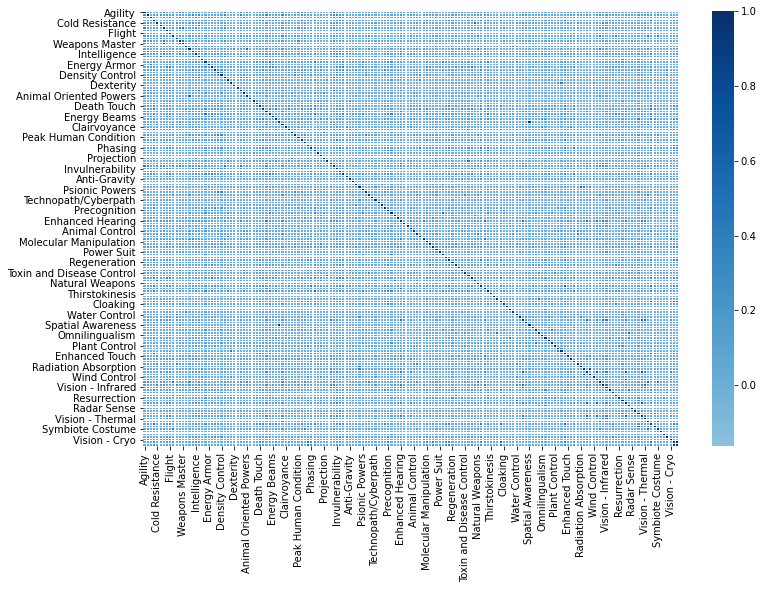

In [33]:
corr = data.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap='Blues', center=0,linewidths=.1)

In the above graph, darker areas can be seen in spots, which indicates the correlation of some superpowers, but due to their number, it is unreadable and does not contain all the variables.

In [34]:
data.corr().unstack().sort_values(ascending=False).drop_duplicates().head(20)

Omniscient              Omniscient              1.000000
Intuitive aptitude      Melting                 0.706576
Vision - Microscopic    Vision - X-Ray          0.659125
Vision - Heat           Vision - X-Ray          0.659125
Vision - Microscopic    Vision - Heat           0.620776
                        Super Breath            0.609733
Vision - Heat           Super Breath            0.609733
Time Travel             Time Manipulation       0.608488
Heat Resistance         Cold Resistance         0.595626
Wallcrawling            Web Creation            0.584234
Illusions               Astral Projection       0.581948
Animal Oriented Powers  Animal Attributes       0.581810
Vision - Telescopic     Vision - Microscopic    0.578905
Radiation Control       Radiation Absorption    0.566883
Reality Warping         Omnipotent              0.560761
Super Breath            Vision - X-Ray          0.549689
Reality Warping         Time Manipulation       0.546961
Durability              Super S

In [35]:
data.corr().unstack().sort_values(ascending=False).drop_duplicates().tail()

Flight                Stealth                -0.132004
Peak Human Condition  Flight                 -0.132598
Weapons Master        Super Strength         -0.137696
Super Strength        Peak Human Condition   -0.147921
Weapons Master        Flight                 -0.162434
dtype: float64

The study of the correlation value shows that a large proportion of the superpowers are positively correlated to some extent. In the case of several superpowers visible above, this is a strong correlation, but moderate and low relationships are much more common. Negative correlations are very weak or absent.

I believe that correlation analysis, like the analysis of association rules, confirms the existence of dependencies and provides the premisis that we are able to group superheroes according to their superpowers.

### Clustering

In [36]:
squared_dist_sum = []
k_list = range(1,60)
for k in k_list:
    km_model = KMeans(n_clusters=k)
    km_model = km_model.fit(data.drop('hero_names', axis=1))
    squared_dist_sum.append(km_model.inertia_)

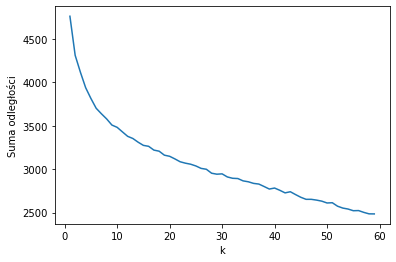

In [37]:
plt.plot(k_list, squared_dist_sum)
plt.xlabel('k')
plt.ylabel('Suma odległości')
plt.show()

The *Elbow method* does not clearly indicate the best number of clusters - you cannot see a clear bend point in the graph, therefore I decided to choose 16 as the number of clusters. Should a problem indicate the need for more homogeneous groups, the number of clusters should be increased.


In [38]:
km_model = KMeans(16)
km_model = km_model.fit(data.drop('hero_names',axis=1))

In [39]:
clusters = km_model.predict(data.drop('hero_names',axis=1))
data['Cluster'] = clusters
data[data['Cluster']==0].head()

,hero_names,Agility,Accelerated Healing,Lantern Power Ring,Dimensional Awareness,Cold Resistance,Durability,Stealth,Energy Absorption,Flight,...,Reality Warping,Odin Force,Symbiote Costume,Speed Force,Phoenix Force,Molecular Dissipation,Vision - Cryo,Omnipresent,Omniscient,Cluster
134,Captain Atom,True,True,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,0
172,Cyborg Superman,False,False,False,False,False,True,False,True,True,...,False,False,False,False,False,False,False,False,False,0
186,Dazzler,True,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,0
239,Flash II,True,True,False,False,False,False,False,True,True,...,False,False,False,True,False,False,False,False,False,0
272,Guy Gardner,False,False,True,False,False,True,False,False,True,...,False,False,False,False,False,False,False,False,False,0


#### t-SNE visualisation

[t-SNE] Computing 82 nearest neighbors...
[t-SNE] Indexed 667 samples in 0.007s...
[t-SNE] Computed neighbors for 667 samples in 0.140s...
[t-SNE] Computed conditional probabilities for sample 667 / 667
[t-SNE] Mean sigma: 0.702342
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.737030
[t-SNE] KL divergence after 1000 iterations: 0.509035


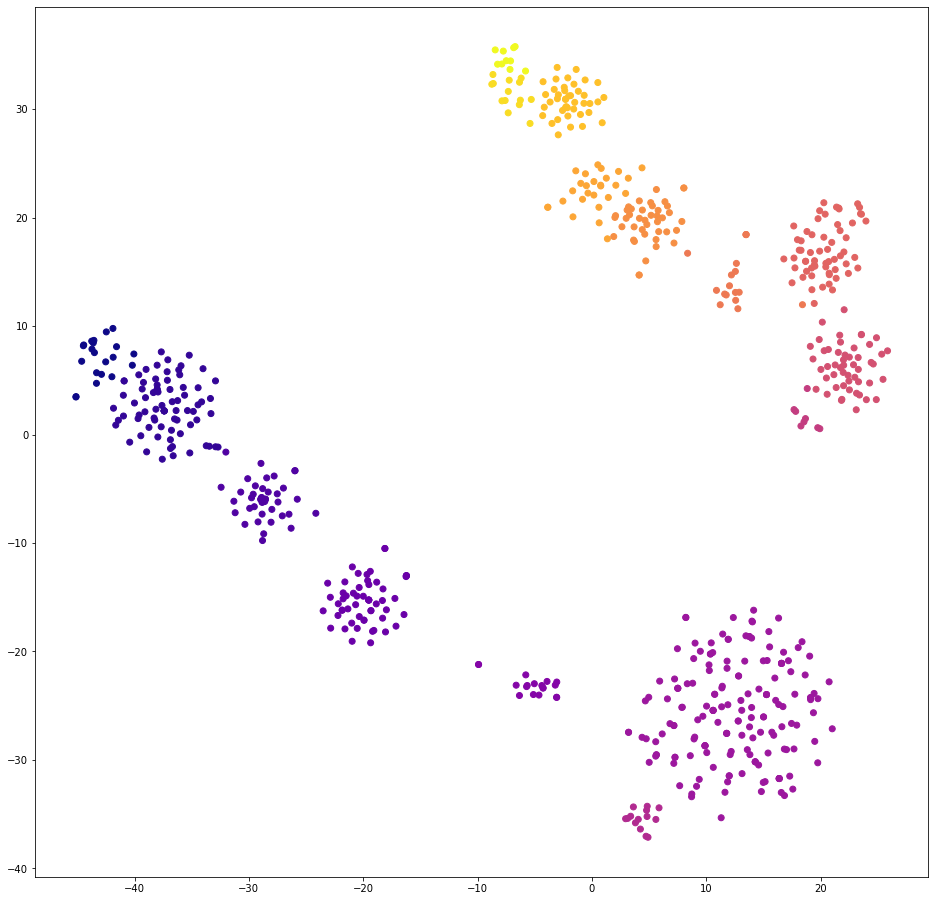

In [40]:
np.random.seed(1)
tsne_clusters=TSNE(perplexity=27, verbose=1)
tsne_results=tsne_clusters.fit_transform(data.drop('hero_names', axis=1))
plt.figure(figsize=(16,16))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=km_model.labels_, cmap='plasma')

Size of individual groups.

<AxesSubplot:ylabel='Cluster'>

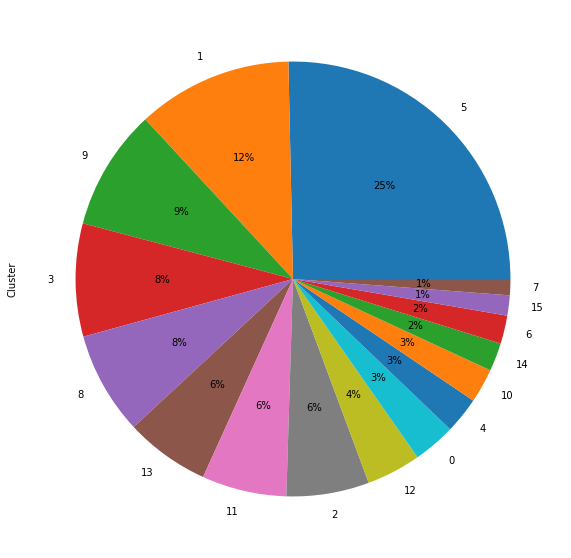

In [41]:
data['Cluster'].value_counts().plot.pie(figsize=(10,10),autopct='%1.f%%')

For every cluster:
5 representatives
5 most common skills + percentage of occurance

In [42]:
for i in range(data['Cluster'].nunique()):
    print("Cluster no: {}".format(i))
    
    group_members= data[data['Cluster']==i]
    group_members_count = data[data['Cluster']==i].count()[0]
    
    print("Representatives: ", end=' ')
    
    reprs_count=5
    if group_members_count < 5:
        reprs_count = group_members_count
        
    for j in range(reprs_count):
        print(group_members.iloc[j]['hero_names'], end='; ')
    print('')
    
    super_powers = data[data['Cluster']==i].drop(['hero_names','Cluster'],axis=1).sum().to_dict()
    super_powers = sorted(super_powers.items(), key=lambda x:x[1], reverse=True)
    
    print('Most common skills with percentage of occurance:')
    for super_power in super_powers[:5]:
        print(super_power[0] + ' --> ' + format((super_power[1]/group_members_count), '.0%'))
    print('##############################################################################')

Cluster no: 0
Representatives:  Captain Atom; Cyborg Superman; Dazzler; Flash II; Guy Gardner; 
Most common skills with percentage of occurance:
Flight --> 90%
Energy Blasts --> 90%
Super Speed --> 90%
Super Strength --> 86%
Stamina --> 76%
##############################################################################
Cluster no: 1
Representatives:  A-Bomb; Absorbing Man; Anti-Spawn; Archangel; Arclight; 
Most common skills with percentage of occurance:
Super Strength --> 94%
Durability --> 87%
Stamina --> 38%
Invulnerability --> 19%
Agility --> 17%
##############################################################################
Cluster no: 2
Representatives:  Adam Strange; Ant-Man; Ant-Man II; Atom IV; Blue Beetle II; 
Most common skills with percentage of occurance:
Intelligence --> 100%
Stealth --> 24%
Flight --> 20%
Weapons Master --> 17%
Agility --> 12%
##############################################################################
Cluster no: 3
Representatives:  Batgirl; Batgirl IV;

You can see from the above printout that most of the groups have been correctly identified on the basis of the dominant superpowers of their members. Many groups were distinguished very precisely.

Group 5 definitely stands out from the rest of the group, with 25% of superheroes who could not be classified into the other groups.

#### Cluster 5

In [43]:
data['powers_count'] = data.sum(axis=1)

In [44]:
data[data['Cluster']==5]['powers_count'].mean()

7.544378698224852

In [45]:
data[data['Cluster']!=5]['powers_count'].mean()

17.6285140562249

As you can see, on average, super heroes from group 0 have less than 8 superpowers, while in the case of the rest the average is over 17 superpowers. This was probably the main reason behind the formation of such a large group of rather not similar superheroes.